In [1]:
from haversine import haversine_vector, Unit
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

import cmdstanpy
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /Users/andrea/.cmdstan
CmdStan version 2.31.0 already installed


True

In [2]:
import pandas as pd

source = "../house12latlong.csv"
df = pd.read_csv(source, index_col=0)
df['Latitude'] = df['Latitude'].str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].str.replace(',', '.').astype(float)
df

,price,Overall.Qual,Garage.Area,Total.Bsmt.SF,X1st.Flr.SF,Full.Bath,AgeofHouse,Mas.Vnr.Area,TotRms.AbvGrd,Fireplaces,Wood.Deck.SF,Open.Porch.SF,Longitude,Latitude
1,215000,6,528.0,1080.0,1656,1,50,112.0,7,2,210,62,-93.619754,42.054035
2,149900,6,452.0,1178.0,1293,2,52,28.0,5,0,280,0,-93.618462,42.053406
3,157500,6,313.0,1008.0,1024,1,50,244.0,5,2,0,0,-93.618182,42.053327
4,124500,6,502.0,882.0,882,1,53,0.0,5,0,0,0,-93.618895,42.053036
5,169000,5,963.0,1617.0,1797,1,49,302.0,7,1,0,0,-93.619262,42.053108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,170000,5,418.0,1389.0,1389,1,31,0.0,6,1,240,38,-93.600190,41.990921
2916,285000,8,482.0,1679.0,1803,2,15,0.0,6,2,129,64,-93.600006,41.989848
2917,188000,7,650.0,996.0,996,2,12,94.0,9,1,190,48,-93.599996,41.989265
2918,231000,6,616.0,1152.0,1152,2,16,0.0,7,1,162,312,-93.600147,41.989185


In [139]:
stan_model = CmdStanModel(stan_file="./marginal-spatial-precision.stan")

18:20:56 - cmdstanpy - INFO - compiling stan file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision.stan to exe file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision
INFO:cmdstanpy:compiling stan file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision.stan to exe file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision
DEBUG:cmdstanpy:cmd: make /tmp/tmp73doc_no/tmpu_alo4yg
cwd: /Users/andrea/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmp73doc_no/tmpu_alo4yg

In [159]:
indexes = df.index.copy().to_numpy()
np.random.shuffle(indexes)
small_df = df.loc[indexes[:300], :]

coords = small_df.loc[:, ["Latitude", "Longitude"]]
dists = haversine_vector(coords, coords, Unit.KILOMETERS, comb=True)

N = small_df.shape[0]
phi=0.7
delta = 1e-5
Sigma = np.ndarray((N,N))

for i in range(0, N):
    for j in range (0,N):
        Sigma[i, j] = np.exp((-1)*phi*dists[i,j]);
    Sigma[i, i]=Sigma[i,i]+delta;

Tau = np.linalg.inv(Sigma) 
(_, logDet) = np.linalg.slogdet(Sigma) # compute log(|det Sigma|)

In [160]:
features = small_df.loc[:, ["Overall.Qual", "Garage.Area", "Total.Bsmt.SF", "X1st.Flr.SF",
                "Mas.Vnr.Area", "TotRms.AbvGrd", "Fireplaces",
                "Wood.Deck.SF", "Full.Bath"]]
                
data = {
    "N": small_df.shape[0],
    "p": features.shape[1],
    # "Y": small_df.loc[:, "price"],
    "Y": np.log(small_df.loc[:, "price"]),
    "X": features,
    "dist": dists,
    "phi": phi,
    "priorsigma2": [5,1],
    "priortau2": [5,1],
    "Tau": Tau,
    "logDet": logDet,
}

stan_fit = stan_model.sample(data=data, chains=4, 
                             parallel_chains=4, 
                             iter_warmup=1000, iter_sampling=5000, max_treedepth=11)

cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp22lohmm4/sl3vlxo7.json
DEBUG:cmdstanpy:cmd: /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision info
cwd: None
18:38:16 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision', 'id=1', 'random', 'seed=69834', 'data', 'file=/tmp/tmp22lohmm4/sl3vlxo7.json', 'output', 'file=/tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=11', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision

18:49:15 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/marginal-spatial-precision', 'id=1', 'random', 'seed=69834', 'data', 'file=/tmp/tmp22lohmm4/sl3vlxo7.json', 'output', 'file=/tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=11', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_1.csv
 console_msgs (if any):
	/tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_0-stdout.txt

18:49:16 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 1 divergent transitions (0.0%)
	Chain 1 had 4999 iterations at max treedepth (100.0%)
	Chain 2 had 2 divergent transitions (0.0%)
	Chain 2 had 4998 iterations at max treedepth (100.0%)
	Chain 3 had 5000 iterations at max treedepth (100.0%)
	Chain 4 had 7 divergent transitions (0.1%)
	Chain 4 had 4993 iterations at max treedepth (99.9%)
	Use function "diagnose()" to see further information.
	Chain 1 had 1 divergent transitions (0.0%)
	Chain 1 had 4999 iterations at max treedepth (100.0%)
	Chain 2 had 2 divergent transitions (0.0%)
	Chain 2 had 4998 iterations at max treedepth (100.0%)
	Chain 3 had 5000 iterations at max treedepth (100.0%)
	Chain 4 had 7 divergent transitions (0.1%)
	Chain 4 had 4993 iterations at max treedepth (99.9%)
	Use function "diagnose()" to see further information.


In [ ]:
import pickle

# Save the result on disk
with open('spatial-stan-results.pickle', 'wb') as f:
    pickle.dump(stan_fit,f)

In [161]:
print(stan_fit.diagnose())

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/diagnose /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_1.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_2.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_3.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_4.csv
cwd: None


Processing csv files: /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_1.csv, /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_2.csv, /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_3.csv, /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_4.csv

Checking sampler transitions treedepth.
19990 of 20000 (99.95%) transitions hit the maximum treedepth limit of 11, or 2^11 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
10 of 20000 (0.05%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to

In [162]:
summary = stan_fit.summary()
summary

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp22lohmm4/stansummary-marginal-spatial-precision-43bsddti.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_1.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_2.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_3.csv /tmp/tmp22lohmm4/marginal-spatial-precisionofyf37op/marginal-spatial-precision-20221220183816_4.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,883.743000,2.449540,48.187100,806.244000,882.198000,967.146000,386.98400,0.171956,1.00916
beta0,10.782200,0.133415,0.265199,10.365700,10.778500,11.232800,3.95125,0.001756,1.72272
beta[1],0.064462,0.001441,0.021309,0.029692,0.064243,0.100364,218.81700,0.097231,1.00789
beta[2],0.000266,0.000007,0.000127,0.000060,0.000265,0.000476,322.63300,0.143362,1.01489
beta[3],0.000084,0.000005,0.000095,-0.000070,0.000083,0.000242,300.94100,0.133723,1.01287
...,...,...,...,...,...,...,...,...,...
spatialEffect[296],0.150428,0.135200,0.241733,-0.293686,0.159824,0.524189,3.19680,0.001421,2.19366
spatialEffect[297],0.028761,0.134017,0.241371,-0.420649,0.037984,0.396374,3.24378,0.001441,2.18260
spatialEffect[298],0.077257,0.135537,0.241841,-0.376828,0.083409,0.452943,3.18381,0.001415,2.18031
spatialEffect[299],0.069799,0.134314,0.248485,-0.381553,0.076001,0.452297,3.42261,0.001521,2.09484


/Users/andrea/miniforge3/lib/python3.10/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (312), generating only 20 plots
  warnings.warn(


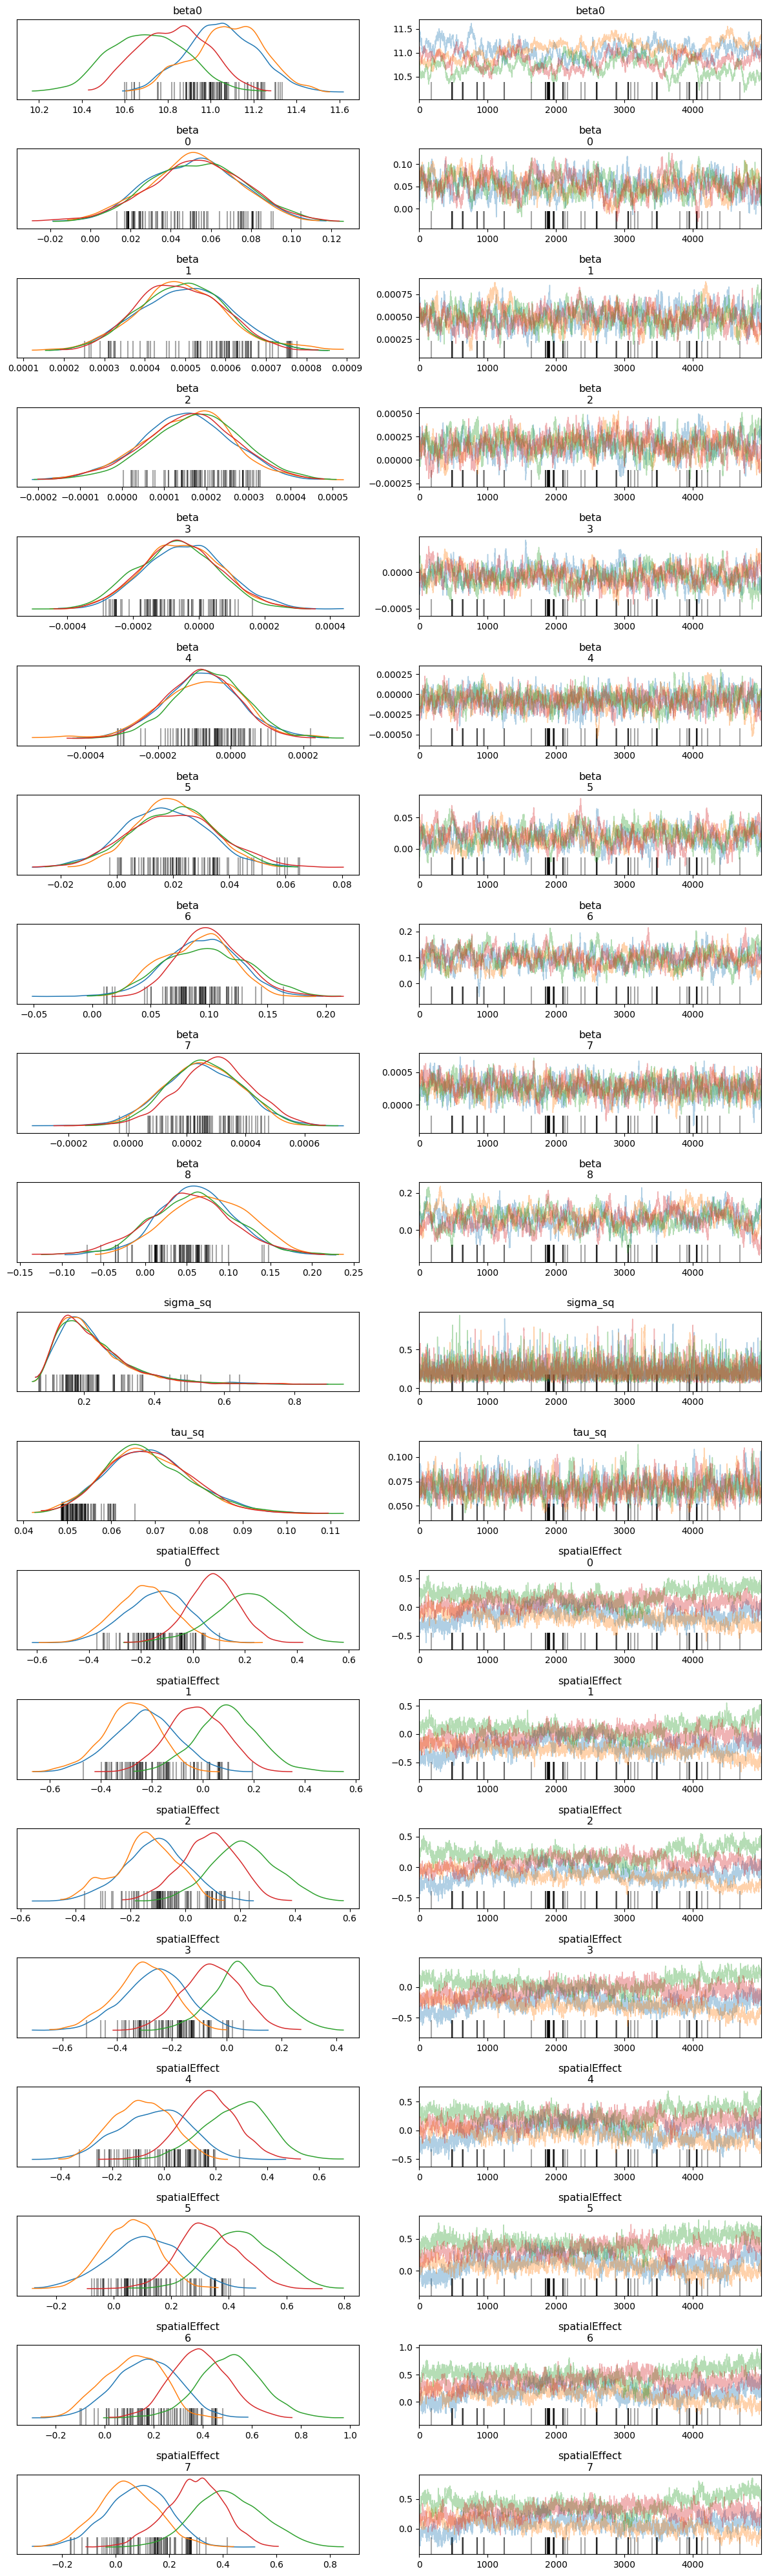

In [158]:
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)

plt.tight_layout()
# plt.savefig("ssvs-bsts.png")
plt.show()